# Analyzing weekdays repr in GPT-2 from Engels et al.

In [ ]:
%cd /home/can/feature_zoo/ 
%load_ext autoreload
%autoreload 2

/home/can/feature_zoo


In [ ]:
import json

fname = "exp/weekdays/temporal_clusters.json"
with open(fname, "r") as f:
    clusters = json.load(f)["clusters"]

clusters

{'days_of_week': {'cluster_id': 138,
  'sae_neuron_indices': [2592,
   4445,
   4663,
   4733,
   6531,
   8179,
   9566,
   20927,
   24185],
  'description': 'SAE neurons representing days of the week (circular structure)',
  'num_neurons': 9},
 'months': {'cluster_id': 251,
  'sae_neuron_indices': [3977,
   4140,
   5993,
   7299,
   9104,
   9401,
   10449,
   11196,
   12661,
   14715,
   17068,
   17528,
   19589,
   21033,
   22043,
   23304],
  'description': 'SAE neurons representing months (circular structure)',
  'num_neurons': 16},
 'years': {'cluster_id': 212,
  'sae_neuron_indices': [1052,
   2753,
   4427,
   6382,
   8314,
   9576,
   9606,
   13551,
   19734,
   20349],
  'description': 'SAE neurons representing years (spiral structure)',
  'num_neurons': 10}}

In [ ]:
days_idxs = clusters["days_of_week"]["sae_neuron_indices"]
days_idxs

[2592, 4445, 4663, 4733, 6531, 8179, 9566, 20927, 24185]

In [ ]:
from src.config import load_config
from src.loading import load_sae

cfg = load_config(overrides=[
    "sae=gpt2_relu",
    "llm=gpt2",
    "data=days"
])

sae = load_sae(cfg)
sae.Ad.shape

/home/can/feature_zoo/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


torch.Size([768, 24576])

In [5]:
W_dec_SD = sae.Ad.T
W_dec_days_sD = W_dec_SD[days_idxs]

# Effective Rank

Should be 2?

In [6]:
import torch as th

U, S, Vh = th.linalg.svd(W_dec_days_sD.float(), full_matrices=False)

In [7]:
Vh.shape

torch.Size([9, 768])

In [8]:
energy = S**2
energy_norm = energy / energy.sum()

(0.0, 1.0)

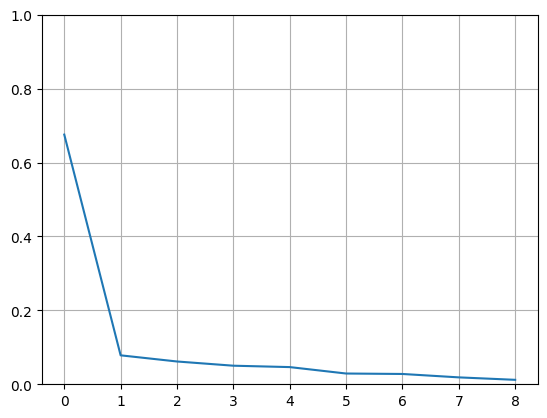

In [9]:
import matplotlib.pyplot as plt
plt.plot(energy_norm.detach().cpu().numpy())
plt.grid()
plt.ylim((0,1))

# Load days of the week data

In [10]:
from src.cache_llm import load_labeled_acts

return_dict = load_labeled_acts(cfg, force_recompute=True)
llm_BD = return_dict["llm_BD"]
llm_BD.shape

LLM Cache: 100%|██████████| 2/2 [00:00<00:00,  7.41it/s]


SAE Cache: 100%|██████████| 5/5 [00:00<00:00, 1067.42it/s]


torch.Size([142, 768])

In [13]:
llm_BC = llm_BD.float() @ Vh.T
llm_BC = llm_BC.detach().cpu().numpy()

In [ ]:
sparse_code_BD = return_dict["codes_BD"].gather(days_idxs[None, :], dim=-1)
sparse_code_BD.shape

In [ ]:
sparse_code_BD

In [28]:
from sklearn.decomposition import PCA

# PCA transform
num_pca_components = 7
EPS = 1e-8
# llm_normalized_BC = llm_BC / (llm_BC.norm(dim=-1, keepdim=True) + EPS)
# llm_normalized_np = llm_normalized_BC.cpu().detach().float().numpy()

pca = PCA(n_components=num_pca_components)
llm_pca_BD = pca.fit_transform(llm_BC)

print(f"PCA transformed shape: {llm_pca_BD.shape}")
print(f"Explained variance ratio: {pca.explained_variance_ratio_}")

PCA transformed shape: (142, 7)
Explained variance ratio: [0.23898783 0.21290644 0.13651514 0.11658466 0.08971734 0.07344075
 0.05719632]


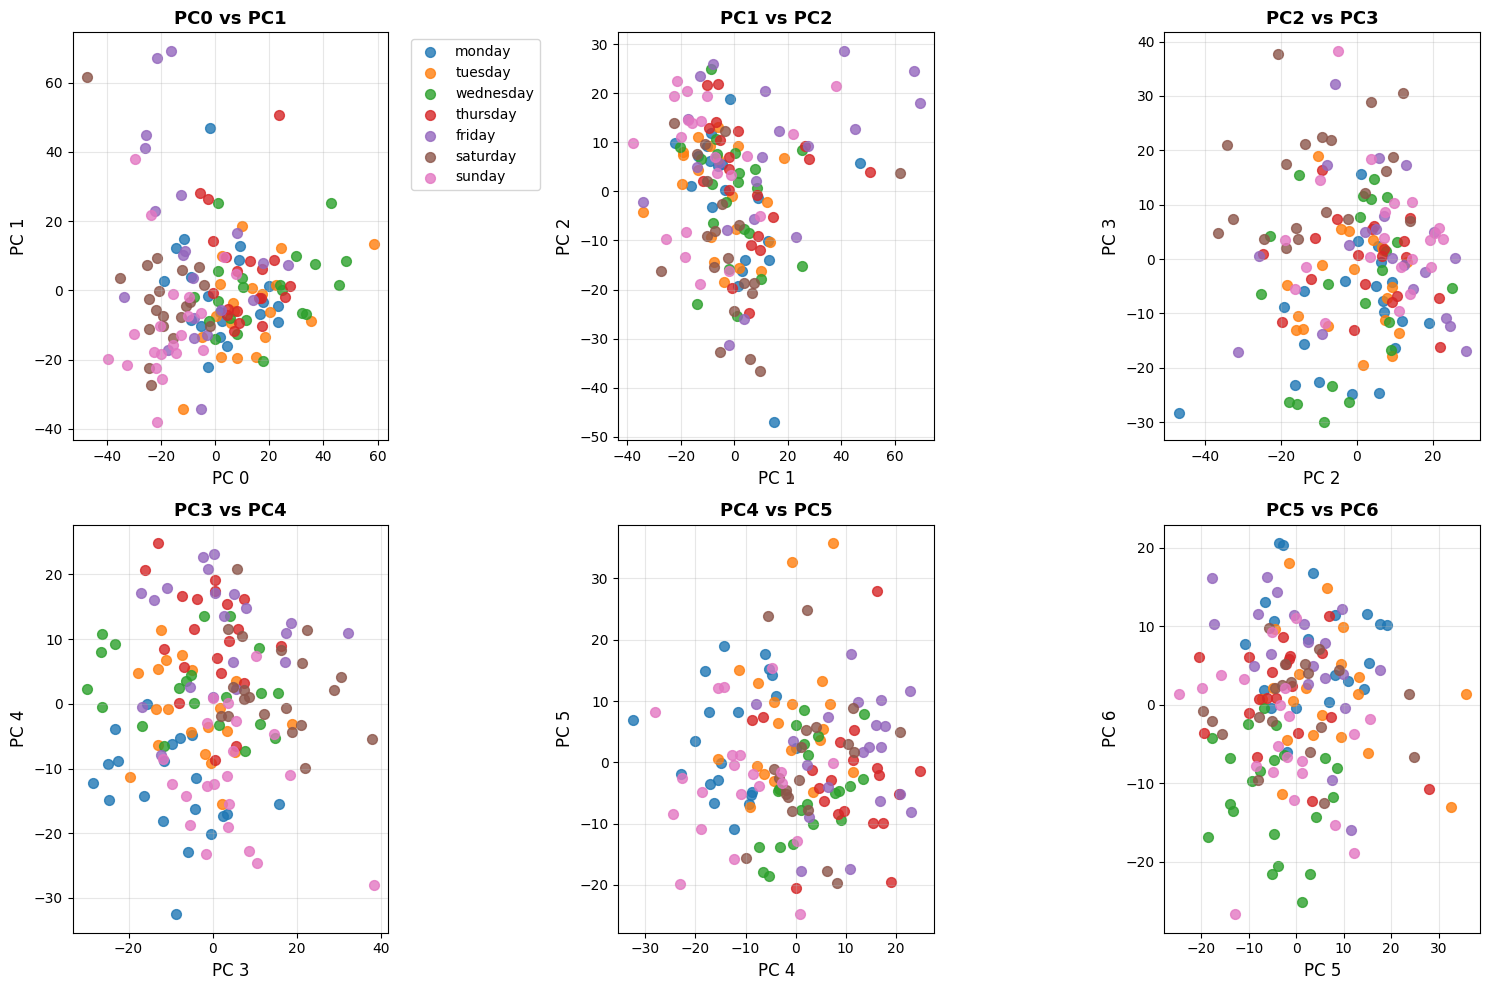

In [29]:
# Create subplots with consecutive PC components
labels = return_dict["labels"]
unique_labels = list(dict.fromkeys(labels))
label_to_idx = {label: idx for idx, label in enumerate(unique_labels)}

# Tab10 colors for categorical coloring
tab10_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
                '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

# Define consecutive PC pairs
pc_pairs = [(i, i+1) for i in range(num_pca_components - 1)]

# Create subplot grid
n_rows = 2
n_cols = 3
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 10))
axes = axes.flatten()

# Plot each consecutive PC pair
for idx, (pc_x, pc_y) in enumerate(pc_pairs):
    if idx >= len(axes):
        break

    ax = axes[idx]

    # Plot each label with different color
    for label in unique_labels:
        mask = [l == label for l in labels]
        label_idx = label_to_idx[label]
        color = tab10_colors[label_idx % len(tab10_colors)]
        ax.scatter(llm_pca_BD[mask, pc_x], llm_pca_BD[mask, pc_y],
                  label=label, color=color, alpha=0.8, s=50)

    # Set labels and title
    ax.set_xlabel(f'PC {pc_x}', fontsize=12)
    ax.set_ylabel(f'PC {pc_y}', fontsize=12)
    ax.set_title(f'PC{pc_x} vs PC{pc_y}', fontsize=13, fontweight='bold')
    ax.grid(True, alpha=0.3)

    # Add legend to first subplot only
    if idx == 0:
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)

# Hide unused subplots
for idx in range(len(pc_pairs), len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

In [32]:
from src.loading import load_llm

llm = load_llm(cfg)
llm

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)